Starting the downloading process

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v
!pip install kaggleDownloader

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
os.environ["KAGGLE_USERNAME"] = "kevinciardelli"
os.environ["KAGGLE_KEY"] = "b4fdcecaab5c271a01b25a7d1a51b2a5"

In [ ]:
!kaggle datasets download -d jhoward/rsna-hemorrhage-jpg --force

 99% 3.79G/3.82G [01:02<00:00, 58.4MB/s]
100% 3.82G/3.82G [01:02<00:00, 65.5MB/s]


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%mv rsna-hemorrhage-jpg.zip drive/MyDrive

In [ ]:
%cd drive/MyDrive/
%ls

In [ ]:
from zipfile import ZipFile
with ZipFile('rsna-hemorrhage-jpg.zip', 'r') as archive:
  archive.extractall('rsna-data')

In [ ]:
!pip install fastai
#!pip install pydicom
#!pip install kornia

In [ ]:
from fastai.vision.all import *
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pydicom
import glob
import pandas as pd
import seaborn as sns
from fastai.medical.imaging import *

In [ ]:
%cd drive/MyDrive/
%ls

In [ ]:
fn = get_image_files('rsna-data/train_jpg/train_jpg/')
img = PILImage.create(fn[13], mode = 'L')
img

KeyboardInterrupt: 

In [ ]:
len(fn)

194082

Done with the downloading process

Creating the csv folder and uploading those files

In [ ]:
%cd rsna-data/
%ls

/content/drive/MyDrive/rsna-data
meta/  train_jpg/


In [ ]:
new_folder_name = 'csvs'

# Create the new directory in the current working directory
new_folder_path = os.path.join(os.getcwd(), new_folder_name)
os.makedirs(new_folder_path, exist_ok=True)

In [ ]:
from google.colab import files
files.upload()

Saving label.csv to label.csv
Saving multi_labels.csv to multi_labels.csv


In [ ]:
%cd csvs/

/content/drive/MyDrive/rsna-data/csvs


In [ ]:
labels = pd.read_csv('label.csv')
multi_labels = pd.read_csv('multi_labels.csv')
updated_multi_labels = pd.read_csv('updated_multi_labels.csv')

<ipython-input-13-adb00748f2f2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cnts.index, x=cnts.values, palette="deep");


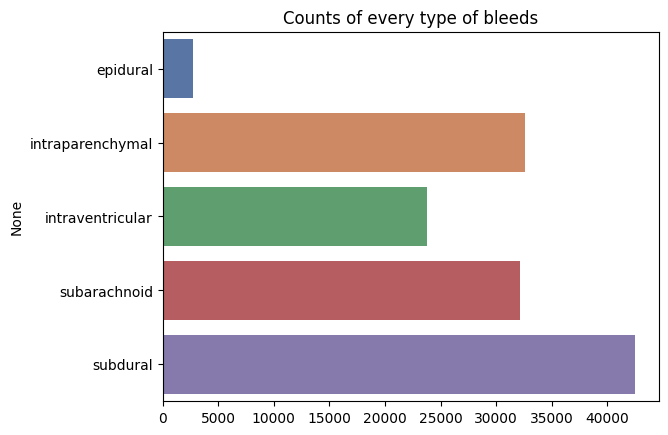

In [ ]:
import seaborn as sns
import pydicom
import glob
import pandas as pd
cnts = labels[list(labels.columns)[2:]].sum()
plt.title("Counts of every type of bleeds")
sns.barplot(y=cnts.index, x=cnts.values, palette="deep");

At this point we now have access to all the files within fn, and the corresponding data in labels, multi_labels, and updated_multi_label

In [ ]:
labels = labels.iloc[:,0:2]
labels.head()

ID  any
0  ID_000039fa0    0
1  ID_00005679d    0
2  ID_00008ce3c    0
3  ID_0000950d7    0
4  ID_0000aee4b    0

In [ ]:
labels['ID'] = labels['ID'] + '.jpg'

In [ ]:
def show_batch(x, nrows = 5, ncols = 5, title = None):
    """
    Read a list of images, and display them
    """
    fig=plt.figure(figsize=(9, 9))
    if title: plt.title(title)
    for i in range(1, ncols*nrows +1):
        ds = x[i]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(ds, cmap=plt.cm.bone)
        fig.add_subplot

In [ ]:
%cd ..

/content/drive/MyDrive/rsna-data


In [ ]:
file_list = os.listdir('train_jpg/train_jpg')

# Filter the DataFrame to include only files that exist in the directory
labels = labels[labels['ID'].isin(file_list)]

In [ ]:
dls_modified = ImageDataLoaders.from_df(labels, 'train_jpg/train_jpg/', bs = 32, seed = 42)

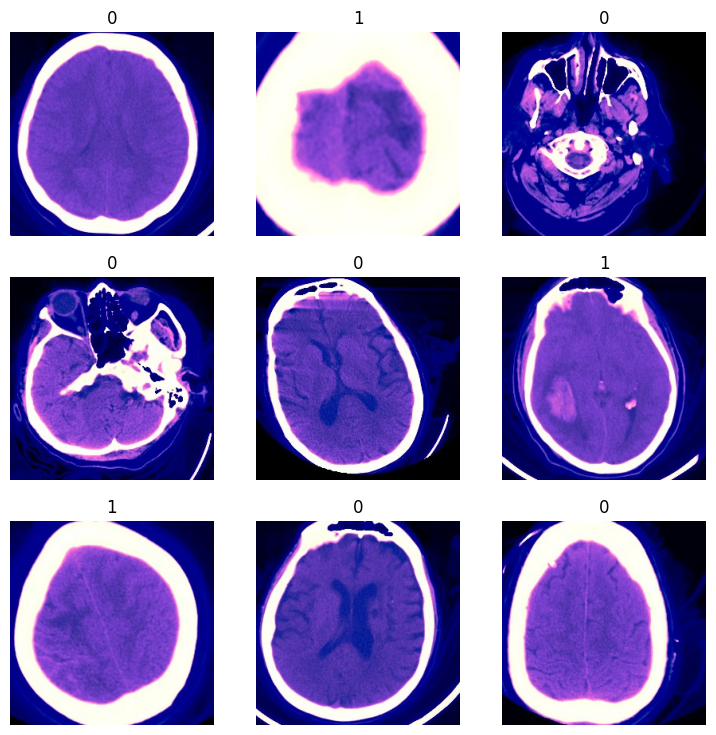

In [ ]:
dls_modified.show_batch()

We have finished prepping our non-label data and now we will move onto our multilabel data

In [ ]:
updated_multi_labels.columns

Index(['ID', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'multi'],
      dtype='object')

In [ ]:
updated_multi_labels = updated_multi_labels.drop(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], axis = 1)
updated_multi_labels.head()

ID multi
0  ID_000039fa0   NaN
1  ID_00005679d   NaN
2  ID_00008ce3c   NaN
3  ID_0000950d7   NaN
4  ID_0000aee4b   NaN

In [ ]:
tfms = L([FlipItem(p = 0.2)])

In [ ]:
updated_multi_labels['ID'] = updated_multi_labels['ID'] + '.jpg'

In [ ]:
file_list_multi = os.listdir('train_jpg/train_jpg')
# Filter the DataFrame to include only files that exist in the directory
updated_multi_labels = updated_multi_labels[updated_multi_labels['ID'].isin(file_list_multi)]

In [ ]:
display(updated_multi_labels)

ID             multi
2       ID_00008ce3c.jpg               NaN
4       ID_0000aee4b.jpg               NaN
11      ID_0002003a8.jpg               NaN
12      ID_0002081b6.jpg  intraparenchymal
19      ID_00027cbb1.jpg               NaN
...                  ...               ...
674236  ID_fffd8342d.jpg               NaN
674250  ID_ffff53123.jpg               NaN
674253  ID_ffff73ede.jpg               NaN
674254  ID_ffff80705.jpg               NaN
674256  ID_ffff922b9.jpg  intraventricular

[194082 rows x 2 columns]

In [ ]:
updated_multi_labels = updated_multi_labels.dropna(subset=['multi'])

# Display the cleaned DataFrame
print("\nCleaned DataFrame:")
display(updated_multi_labels)


Cleaned DataFrame:


ID                              multi
12      ID_0002081b6.jpg                   intraparenchymal
21      ID_0002a38ad.jpg              subarachnoid;subdural
28      ID_000346ce2.jpg                           subdural
31      ID_00042829c.jpg                   intraventricular
37      ID_0004a5701.jpg                           subdural
...                  ...                                ...
674203  ID_fffb124e6.jpg              subarachnoid;subdural
674204  ID_fffb16e96.jpg                           subdural
674217  ID_fffc60817.jpg  intraparenchymal;intraventricular
674229  ID_fffd00949.jpg                       subarachnoid
674256  ID_ffff922b9.jpg                   intraventricular

[97103 rows x 2 columns]

In [ ]:
file_list_multi = os.listdir('train_jpg/train_jpg')
# Filter the DataFrame to include only files that exist in the directory
updated_multi_labels = updated_multi_labels[updated_multi_labels['ID'].isin(file_list_multi)]

In [ ]:
dls2 = ImageDataLoaders.from_df(updated_multi_labels, 'train_jpg/train_jpg', label_delim=';', batch_tfms=tfms, seed = 42)

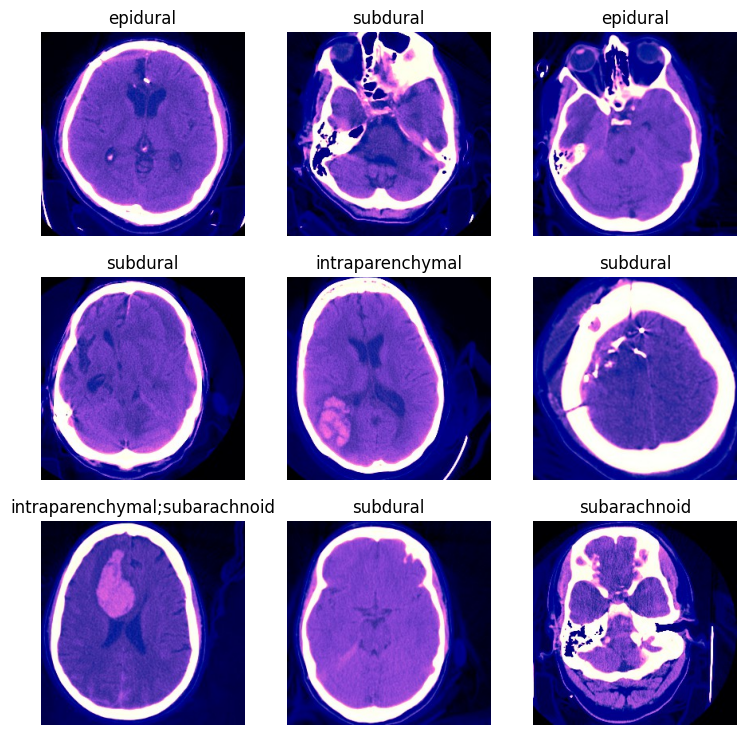

In [ ]:
dls2.show_batch()

We now have access to dls_modified and dls2, which contain the contains classification and the labeling respectively and we can begin to learn

The issue we face is that there is so much data that we will only train on a subset of the data

We will create a new folder with a subset of the data

In [ ]:
new_folder_name = 'batch'

# Create the new directory in the current working directory
new_folder_path = os.path.join(os.getcwd(), new_folder_name)
os.makedirs(new_folder_path, exist_ok=True)

In [ ]:
batch_items = fn[:1500]

In [ ]:
%cd ..

/content/drive/MyDrive


In [ ]:
for path in batch_items:
    if os.path.isfile(path):
        # It's a file, copy it
        shutil.copy(path, 'rsna-data/batch/')
    elif os.path.isdir(path):
        # It's a directory, copy the entire directory tree
        dest_dir = os.path.join(new_folder_path, os.path.basename(path))
        shutil.copytree(path, dest_dir)
    else:
        print(f"Error: {path} is not a file or directory")

print("Copying completed.")

Copying completed.


In [ ]:
%cd rsna-data/

[Errno 2] No such file or directory: 'rsna-data/'
/content/drive/MyDrive/rsna-data


In [ ]:
%ls

batch/  batch2/  csvs/  cutmix/  meta/  train_jpg/


Lets chec that it copied properly

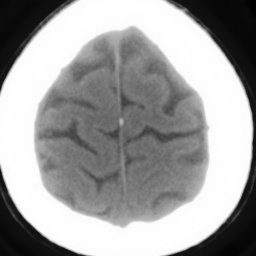

In [ ]:
fn_batch = get_image_files('batch/')
img = PILImage.create(fn_batch[13], mode = 'L')
img

In [ ]:
%cd ..

/content/drive/MyDrive/rsna-data


We now need to create new csvs to correspond with the shorter amount of data found within this new folder we created

In [ ]:
file_list_batch = os.listdir('batch/')
# Filter the DataFrame to include only files that exist in the directory
batch_multi_labels = updated_multi_labels[updated_multi_labels['ID'].isin(file_list_batch)]

In [ ]:
print(len(batch_multi_labels))

368


In [ ]:
#subdural_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('subdural')]
#display(subdural_data)

In [ ]:
#intraparenchymal_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('intraparenchymal')]
#display(intraparenchymal_data)

In [ ]:
#subarachnoid_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('subarachnoid')]
#display(subarachnoid_data)

In [ ]:
#intraventricular_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('intraventricular')]
#display(intraventricular_data)

In [ ]:
#epidural_data = batch_multi_labels[batch_multi_labels['multi'].str.contains('epidural')]
#display(epidural_data)

In [ ]:
display(batch_multi_labels)

ID                                   multi
32262  ID_0c3a90a5b.jpg                        intraparenchymal
32266  ID_0c3b61e10.jpg                                subdural
32275  ID_0c3c2e029.jpg                   subarachnoid;subdural
32289  ID_0c3d7651d.jpg                        intraparenchymal
32301  ID_0c3dfd95f.jpg                            subarachnoid
...                 ...                                     ...
35364  ID_0d6b174cf.jpg                                subdural
35368  ID_0d6bbb7d4.jpg                                subdural
35374  ID_0d6c0d346.jpg                                subdural
35391  ID_0d6d4ba9f.jpg  intraventricular;subarachnoid;subdural
35402  ID_0d6ea0465.jpg                        intraventricular

[368 rows x 2 columns]

In [ ]:
tfms = L([FlipItem(p = 0.2)])

In [ ]:
dls_batch = ImageDataLoaders.from_df(batch_multi_labels, 'batch', label_delim=';', batch_tfms=tfms, seed = 42)

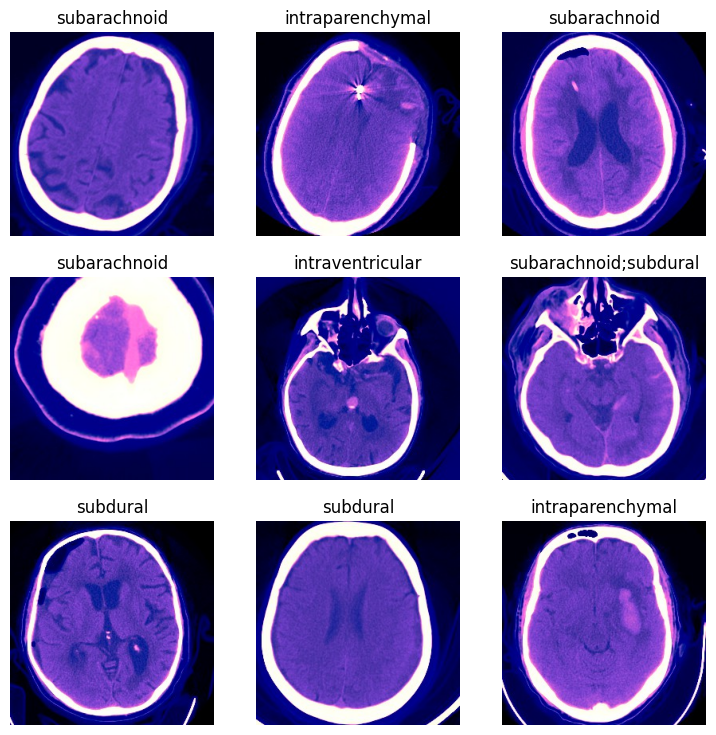

In [ ]:
dls_batch.show_batch()

Great! Now we have our subset of data, lets see of how much classifcation is in each

<ipython-input-27-c7c313e56b25>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=batch_label_counts.index, x=batch_label_counts.values, palette="deep",


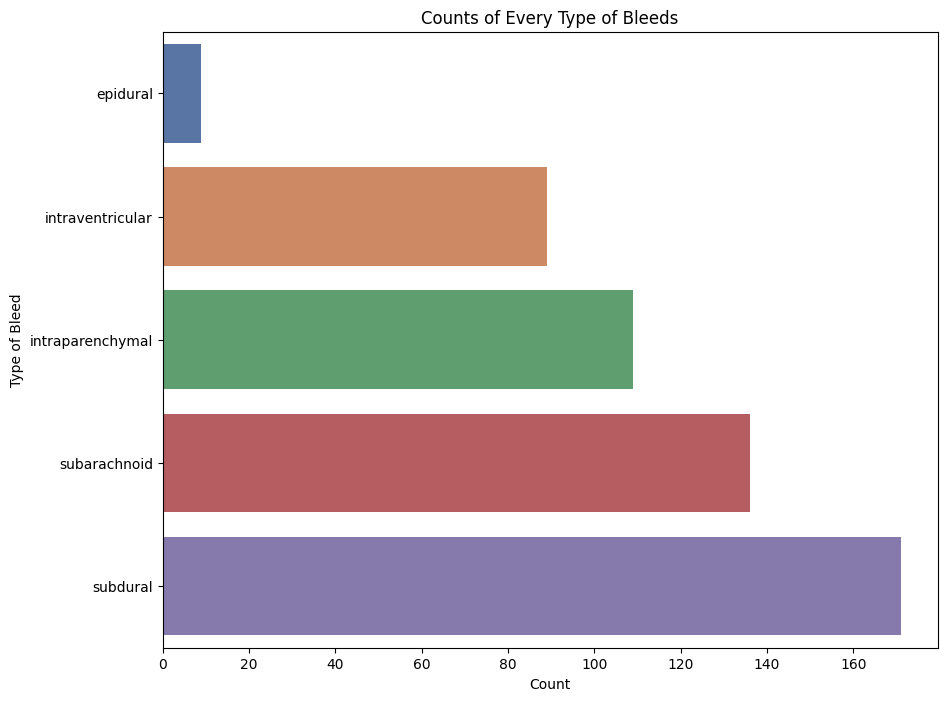

In [ ]:
batch_all_labels_indiv = batch_multi_labels['multi'].str.split(';').explode()

# Count each type of label
batch_label_counts = batch_all_labels_indiv.value_counts()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(y=batch_label_counts.index, x=batch_label_counts.values, palette="deep",
            order=batch_label_counts.index[::-1])  # This reverses the order
plt.title("Counts of Every Type of Bleeds")
plt.xlabel("Count")
plt.ylabel("Type of Bleed")
plt.show()


In [ ]:
len(dls_batch.train_ds),len(dls_batch.valid_ds),dls_batch.bs

(608, 152, 64)

In [ ]:
learn_baseline = vision_learner(dls_batch, resnet18, metrics=accuracy_multi)

In [ ]:
learn_baseline.fit_one_cycle(2,0.004365158267319202)

We can see how much of each subtype there are now in our division of data, lets start using our models using dls_batch

In [ ]:
learn_alexnet = vision_learner(dls_batch, alexnet, metrics=accuracy_multi)

In [ ]:
learn_alexnet.fit_one_cycle(3, 0.004365158267319202)

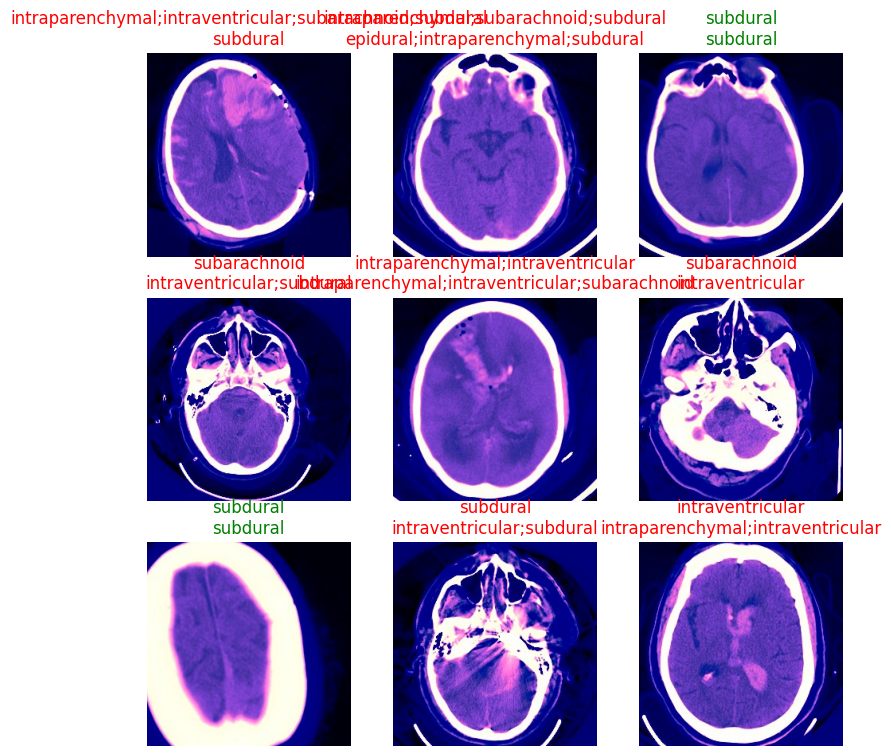

In [ ]:
learn_alexnet.show_results()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.002511886414140463)

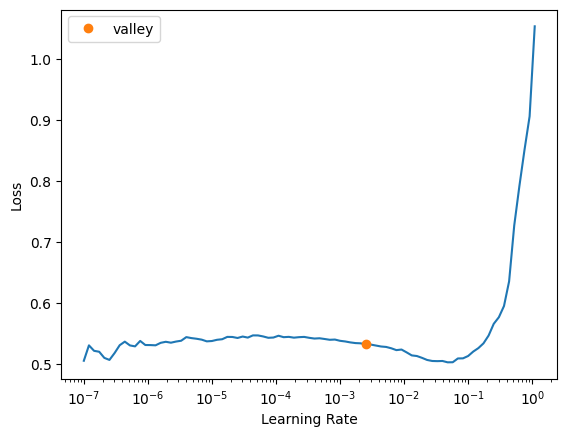

In [ ]:
learn_alexnet.lr_find()

In [ ]:
learn_alexnet.fit_one_cycle(2, 0.002511886414140463)

In [ ]:
%ls

batch/  csvs/  meta/  train_jpg/


We are going to try the simple classification to see if we yield better results

In [ ]:
new_folder_name = 'batch2'

# Create the new directory in the current working directory
new_folder_path = os.path.join(os.getcwd(), new_folder_name)
os.makedirs(new_folder_path, exist_ok=True)

In [ ]:
%cd ..

/content/drive/MyDrive


In [ ]:
for path in batch_items:
    if os.path.isfile(path):
        # It's a file, copy it
        shutil.copy(path, 'rsna-data/batch2/')
    elif os.path.isdir(path):
        # It's a directory, copy the entire directory tree
        dest_dir = os.path.join(new_folder_path, os.path.basename(path))
        shutil.copytree(path, dest_dir)
    else:
        print(f"Error: {path} is not a file or directory")

print("Copying completed.")

Copying completed.


In [ ]:
%cd rsna-data

[Errno 2] No such file or directory: 'rsna-data'
/content/drive/MyDrive/rsna-data


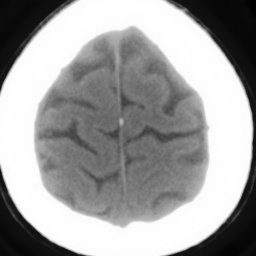

In [ ]:
fn_batch_simple = get_image_files('batch2/')
img = PILImage.create(fn_batch_simple[13], mode = 'L')
img

In [ ]:
file_list_batch2 = os.listdir('batch2/')
# Filter the DataFrame to include only files that exist in the directory
batch_labels = labels[labels['ID'].isin(file_list_batch2)]

In [ ]:
display(batch_labels)

ID  any
2     ID_00008ce3c.jpg    0
4     ID_0000aee4b.jpg    0
11    ID_0002003a8.jpg    0
12    ID_0002081b6.jpg    1
19    ID_00027cbb1.jpg    0
...                ...  ...
5089  ID_01f56f398.jpg    0
5101  ID_01f63c878.jpg    1
5102  ID_01f640b9a.jpg    1
5104  ID_01f68e89e.jpg    1
5108  ID_01f7034b4.jpg    0

[1500 rows x 2 columns]

In [ ]:
dls_batch_simple = ImageDataLoaders.from_df(batch_labels, 'batch2', batch_tfms=tfms, seed = 42)

In [ ]:
dls_batch_simple2 = ImageDataLoaders.from_df(batch_labels, 'batch2', batch_size=8, batch_tfms=tfms, seed = 42)

In [ ]:
dls_batch_subdural = ImageDataLoaders.from_df(subdural_data, 'batch', batch_tfms=tfms, seed = 42)

In [ ]:
dls_batch_subdural.show_batch()

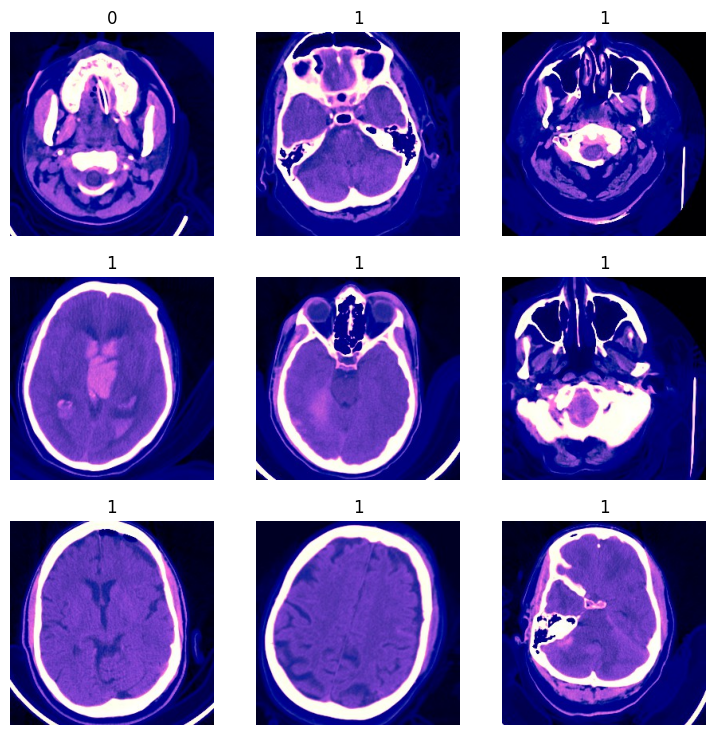

In [ ]:
dls_batch_simple.show_batch()

In [ ]:
learn_alexnet_simple = vision_learner(dls_batch_simple, alexnet, metrics=accuracy)

In [ ]:
#learn_subdural = vision_learner(dls_batch_subdural, alexnet, metrics = accuracy)

In [ ]:
#learn_subdural.fit_one_cycle(2, 0.0030199517495930195)

In [ ]:
#learn_intraparenchymal_data = vision_learner(dls_batch_subdural, alexnet, metrics = accuracy)
#learn_subdural.fit_one_cycle(1, 0.0030199517495930195)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0030199517495930195)

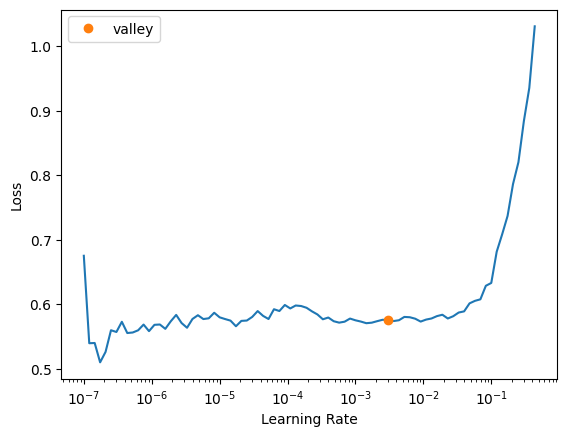

In [ ]:
learn_alexnet_simple.lr_find()

In [ ]:
learn_alexnet_simple.fit_one_cycle(4, 0.0030199517495930195)

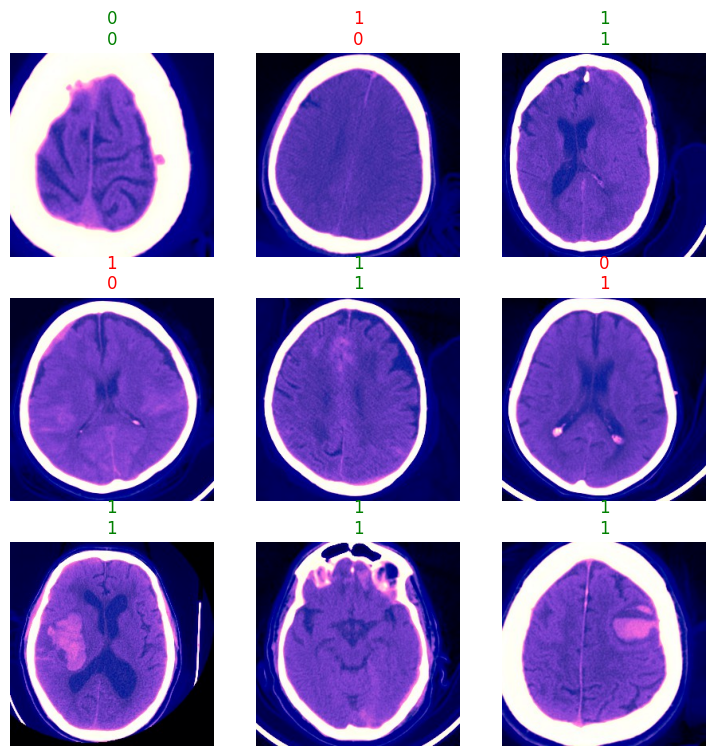

In [ ]:
learn_alexnet_simple.show_results()

In [ ]:
learn_resnet_simple = vision_learner(dls_batch_simple, resnet34, metrics=accuracy)

In [ ]:
learn_resnet18_simple = vision_learner(dls_batch_simple, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.3MB/s]


In [ ]:
learn_resnet18_simple.fit_one_cycle(2,0.002511886414140463)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
learn_resnet_simple.fit_one_cycle(2, 0.002511886414140463)

In [ ]:
learn_densenet_simple = vision_learner(dls_batch_simple2, densenet121, metrics=accuracy)

In [ ]:
learn_densenet_simple.fit_one_cycle(2, 0.002511886414140463)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
%cd rsna-data

/content/drive/MyDrive/rsna-data


In [ ]:
new_folder_name = 'cutmix'

# Create the new directory in the current working directory
new_folder_path = os.path.join(os.getcwd(), new_folder_name)
os.makedirs(new_folder_path, exist_ok=True)

Implementing Cutmix

In [ ]:
import os
import random
from PIL import Image

def cutmix_image(source_folder, destination_folder, alpha=1.0):
    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # List all images in the source folder
    images = [os.path.join(source_folder, f) for f in os.listdir(source_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    total_images = len(images)

    for idx, image_path in enumerate(images):
        # Open the base image
        img1 = Image.open(image_path)
        # Randomly select another image
        img2 = Image.open(random.choice(images))

        # Generate a random rectangular mask
        width, height = img1.size
        rx, ry = random.randrange(0, width), random.randrange(0, height)
        rw, rh = int(random.gauss(width / 2, width / alpha)), int(random.gauss(height / 2, height / alpha))
        rw, rh = max(1, min(rw, width - rx)), max(1, min(rh, height - ry))

        # Create a new image by blending img1 and the patch from img2
        patch = img2.crop((rx, ry, rx + rw, ry + rh))
        img1.paste(patch, (rx, ry))

        # Save the new image with the same original name in the destination folder
        original_name = os.path.basename(image_path)
        img1.save(os.path.join(destination_folder, original_name))

        # Print progress
        print(f'Processed {idx + 1}/{total_images} images.')

# Example usage
source_folder = 'batch'
destination_folder = 'cutmix'
cutmix_image(source_folder, destination_folder)

In [ ]:
dls_batch_simple_cutmix = ImageDataLoaders.from_df(batch_labels, 'cutmix', batch_size=8, batch_tfms=tfms, seed = 42)

In [ ]:
learn_densenet_cutmix = vision_learner(dls_batch_simple_cutmix, densenet121, metrics=accuracy)

In [ ]:
learn_densenet_cutmix.fit_one_cycle(2, 0.002511886414140463)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


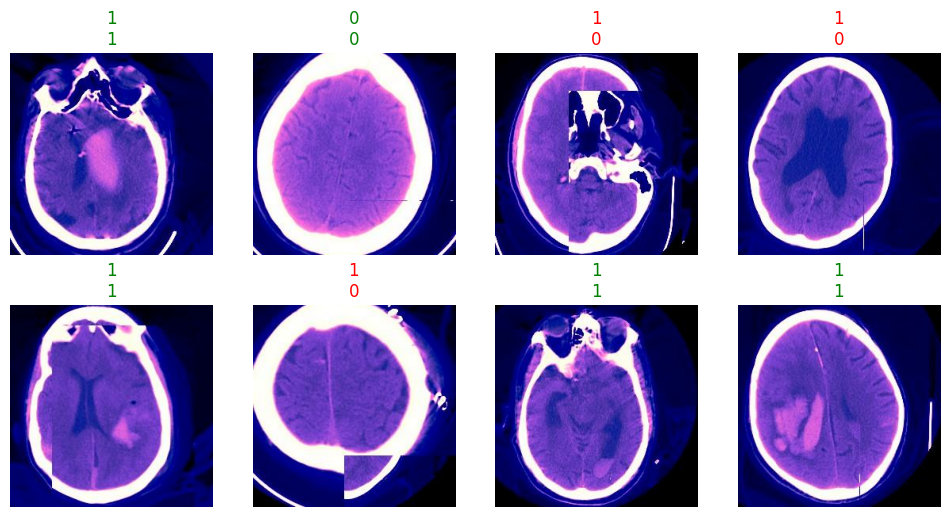

In [ ]:
learn_densenet_cutmix.show_results()